In [3]:
!pip install medmnist torch torchvision torchmetrics matplotlib scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 46.0 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import medmnist
from medmnist import INFO
from torchmetrics.classification import MultilabelAUROC, MultilabelF1Score
import matplotlib.pyplot as plt
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Create a directory to save models and logs
save_path = "/content/drive/MyDrive/chestmnist_model"
os.makedirs(save_path, exist_ok=True)

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Mounted at /content/drive


In [5]:
data_flag = 'chestmnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])
label_names = [str(i) for i in range(14)]

# transforms: normalize to [-1,1]
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[.5], std=[.5])
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load splits
train_dataset = DataClass(split='train', transform=train_transform, download=True)
val_dataset = DataClass(split='val', transform=val_transform, download=False)
test_dataset = DataClass(split='test', transform=val_transform, download=False)

# DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

100%|██████████| 82.8M/82.8M [00:33<00:00, 2.46MB/s]


In [6]:
class VGGSmall(nn.Module):
    def __init__(self, num_classes=14):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, num_classes), nn.Sigmoid()
        )
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

model = VGGSmall(num_classes=14).to(device)

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# metrics (multi-label setup)
auroc = MultilabelAUROC(num_labels=14).to(device)
f1_micro = MultilabelF1Score(num_labels=14, average='micro').to(device)
f1_macro = MultilabelF1Score(num_labels=14, average='macro').to(device)

# for plotting
train_losses, val_losses = [], []
train_aucs, val_aucs = [], []

In [ ]:
best_val_loss = float('inf')
epochs_no_improve = 0
patience = 3
num_epochs = 20

for epoch in range(1, num_epochs+1):
    # training
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).float()  # convert to float for BCE
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # validation
    model.eval()
    running_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device).float()
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            all_preds.append(outputs)
            all_labels.append(labels)
    epoch_val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    # compute validation AUC
    preds = torch.cat(all_preds)
    labs  = torch.cat(all_labels)
    epoch_val_auc = auroc(preds, labs.int()).item()
    val_aucs.append(epoch_val_auc)

    print(f"Epoch {epoch}/{num_epochs} |" \
          f" Train Loss: {epoch_train_loss:.4f} |" \
          f" Val Loss: {epoch_val_loss:.4f} |" \
          f" Val AUC: {epoch_val_auc:.4f}")

    # early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), f'{save_path}/best_model.pth')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered")
            break

Epoch 1/20 | Train Loss: 0.1848 | Val Loss: 0.1737 | Val AUC: 0.6506
Epoch 2/20 | Train Loss: 0.1783 | Val Loss: 0.1717 | Val AUC: 0.6732
Epoch 3/20 | Train Loss: 0.1764 | Val Loss: 0.1695 | Val AUC: 0.6940
Epoch 4/20 | Train Loss: 0.1751 | Val Loss: 0.1730 | Val AUC: 0.6996
Epoch 5/20 | Train Loss: 0.1741 | Val Loss: 0.1683 | Val AUC: 0.7034
Epoch 6/20 | Train Loss: 0.1731 | Val Loss: 0.1664 | Val AUC: 0.7144
Epoch 7/20 | Train Loss: 0.1722 | Val Loss: 0.1693 | Val AUC: 0.7111
Epoch 8/20 | Train Loss: 0.1713 | Val Loss: 0.1658 | Val AUC: 0.7223
Epoch 9/20 | Train Loss: 0.1708 | Val Loss: 0.1662 | Val AUC: 0.7283
Epoch 10/20 | Train Loss: 0.1704 | Val Loss: 0.1643 | Val AUC: 0.7339
Epoch 11/20 | Train Loss: 0.1697 | Val Loss: 0.1647 | Val AUC: 0.7345
Epoch 12/20 | Train Loss: 0.1693 | Val Loss: 0.1637 | Val AUC: 0.7403
Epoch 13/20 | Train Loss: 0.1689 | Val Loss: 0.1641 | Val AUC: 0.7406
Epoch 14/20 | Train Loss: 0.1686 | Val Loss: 0.1630 | Val AUC: 0.7435
Epoch 15/20 | Train Loss: 0.1

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

model.load_state_dict(torch.load(f'{save_path}/best_model.pth'))
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        all_preds.append(outputs.cpu())
        all_labels.append(labels.cpu())
preds = torch.cat(all_preds)
labels = torch.cat(all_labels)

# threshold at 0.5 for each class
preds_bin = (preds > 0.5).int()

# classification report
print(classification_report(labels, preds_bin, target_names=label_names))

# compute per-class AUC
for i, name in enumerate(label_names):
    auc_val = roc_auc_score(labels[:, i], preds[:, i])
    print(f"AUC {name}: {auc_val:.4f}")

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2420
           1       0.00      0.00      0.00       582
           2       0.64      0.10      0.17      2754
           3       0.78      0.00      0.00      3938
           4       0.00      0.00      0.00      1133
           5       0.00      0.00      0.00      1335
           6       0.00      0.00      0.00       242
           7       0.00      0.00      0.00      1089
           8       0.00      0.00      0.00       957
           9       0.00      0.00      0.00       413
          10       0.00      0.00      0.00       509
          11       0.00      0.00      0.00       362
          12       0.00      0.00      0.00       734
          13       0.00      0.00      0.00        42

   micro avg       0.65      0.02      0.03     16510
   macro avg       0.10      0.01      0.01     16510
weighted avg       0.29      0.02      0.03     16510
 samples avg       0.01   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

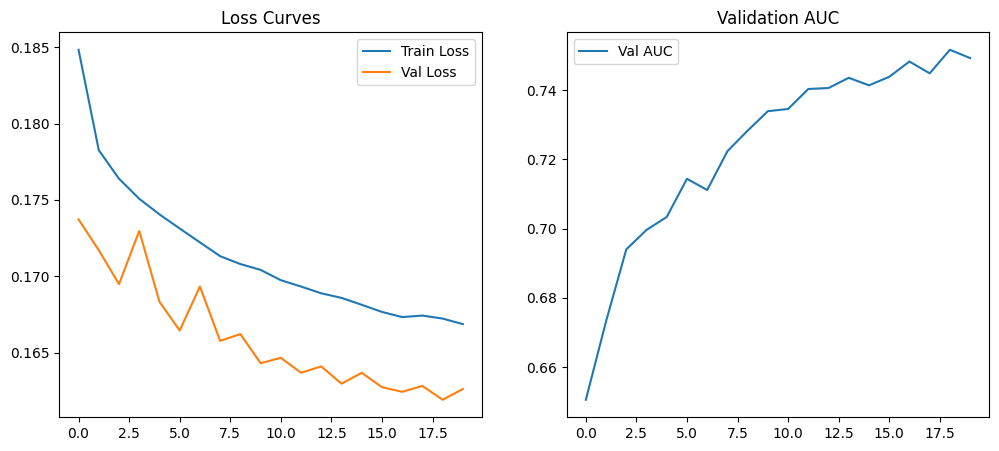

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend(); plt.title('Loss Curves')

plt.subplot(1,2,2)
plt.plot(val_aucs, label='Val AUC')
plt.legend(); plt.title('Validation AUC')

plt.savefig(f"{save_path}/training_curves.png")
plt.show()

In [10]:
# ——— Ćelija 8: Evaluacija modela na testnom skupu ———

import torch
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, f1_score

# 1) Priprema uređaja i učitavanje najboljeg modela
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VGGSmall(num_classes=14).to(device)
model.load_state_dict(torch.load(f'{save_path}/best_model.pth', map_location=torch.device('cpu')))
model.eval()

# 2) Prikupljanje stvarnih labela, predikcija i vjerovatnoća
ground_truth = []
predictions  = []
probabilities = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        logits = model(images)
        probs  = torch.sigmoid(logits).cpu().numpy()
        preds  = (probs >= 0.5).astype(int)

        probabilities.append(probs)
        predictions.append(preds)
        ground_truth.append(labels.numpy())

# 3) Spajanje batch-eva
prob_matrix = np.vstack(probabilities)
pred_matrix = np.vstack(predictions)
true_matrix = np.vstack(ground_truth)

# 4) Detaljni izvještaj performansi
print("Classification Report (precision, recall, f1-score):\n")
print(classification_report(
    true_matrix, pred_matrix,
    target_names=label_names,
    zero_division=0
))

# 5) AUC po klasi
print("\nAUC po klasi:")
aucs = roc_auc_score(true_matrix, prob_matrix, average=None)
for name, auc in zip(label_names, aucs):
    print(f"{name:20s}: {auc:.4f}")

# 6) Mikro i makro F1-score
micro_f1 = f1_score(true_matrix, pred_matrix, average='micro')
macro_f1 = f1_score(true_matrix, pred_matrix, average='macro')
print(f"\nMicro F1-score: {micro_f1:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")


Classification Report (precision, recall, f1-score):

              precision    recall  f1-score   support

           0       0.11      1.00      0.19      2420
           1       0.03      1.00      0.05       582
           2       0.12      1.00      0.22      2754
           3       0.18      1.00      0.30      3938
           4       0.05      1.00      0.10      1133
           5       0.06      1.00      0.11      1335
           6       0.01      1.00      0.02       242
           7       0.05      1.00      0.09      1089
           8       0.04      1.00      0.08       957
           9       0.02      1.00      0.04       413
          10       0.02      1.00      0.04       509
          11       0.02      1.00      0.03       362
          12       0.03      1.00      0.06       734
          13       0.00      1.00      0.00        42

   micro avg       0.05      1.00      0.10     16510
   macro avg       0.05      1.00      0.10     16510
weighted avg       0.10   

In [9]:
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np

# 1) Učitaj najbolji model
model.load_state_dict(torch.load(f'{save_path}/best_model.pth', map_location=torch.device('cpu')))
model.eval()

# 2) Prikupi sve vjerovatnoće i stvarne labele s VALIDACIJE (ne test)
val_probs = []
val_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = torch.sigmoid(model(images)).cpu().numpy()
        val_probs.append(outputs)
        val_labels.append(labels.numpy())

val_probs = np.vstack(val_probs)
val_labels = np.vstack(val_labels)

# 3) Nađi optimalni threshold po klasi (koji daje najbolji f1)
best_thresholds = []
for i in range(val_labels.shape[1]):
    best_f1 = 0
    best_thresh = 0.5
    for t in np.arange(0.1, 0.9, 0.01):
        preds = (val_probs[:, i] > t).astype(int)
        f1 = f1_score(val_labels[:, i], preds, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = t
    best_thresholds.append(best_thresh)

print("Optimalni pragovi po klasi:", best_thresholds)

# 4) Testiraj model na test skupu koristeći optimalne pragove
test_probs = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = torch.sigmoid(model(images)).cpu().numpy()
        test_probs.append(outputs)
        test_labels.append(labels.numpy())

test_probs = np.vstack(test_probs)
test_labels = np.vstack(test_labels)

# 5) Pretvori u binarne predikcije po optimalnim pragovima
test_preds = np.zeros_like(test_probs)
for i, t in enumerate(best_thresholds):
    test_preds[:, i] = (test_probs[:, i] > t).astype(int)

# 6) Rezultati
print("\nClassification Report (sa optimalnim pragovima):")
print(classification_report(test_labels, test_preds, target_names=label_names, zero_division=0))

print("\nAUC po klasi:")
for i, name in enumerate(label_names):
    auc = roc_auc_score(test_labels[:, i], test_probs[:, i])
    print(f"{name:20s}: {auc:.4f}")

print("\nMicro F1-score:", f1_score(test_labels, test_preds, average='micro'))
print("Macro F1-score:", f1_score(test_labels, test_preds, average='macro'))


Optimalni pragovi po klasi: [np.float64(0.5399999999999998), np.float64(0.5199999999999998), np.float64(0.5599999999999997), np.float64(0.5399999999999998), np.float64(0.5199999999999998), np.float64(0.5199999999999998), np.float64(0.5099999999999998), np.float64(0.5199999999999998), np.float64(0.5299999999999998), np.float64(0.5199999999999998), np.float64(0.5099999999999998), np.float64(0.5099999999999998), np.float64(0.5199999999999998), np.float64(0.1)]

Classification Report (sa optimalnim pragovima):
              precision    recall  f1-score   support

           0       0.24      0.51      0.33      2420
           1       0.20      0.32      0.25       582
           2       0.39      0.52      0.45      2754
           3       0.27      0.58      0.36      3938
           4       0.14      0.32      0.19      1133
           5       0.11      0.20      0.14      1335
           6       0.03      0.13      0.05       242
           7       0.16      0.40      0.23      1089
 

In [17]:
# Učitamo 2 slike iz test skupa
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Prva slika bez bolesti (sve 0)
for img, label in test_dataset:
    if label.sum() == 0:  # zdrava slika
        healthy_img = TF.to_pil_image(img)
        healthy_img.save("/content/drive/MyDrive/chestmnist_model/healthy_test.jpg")
        break

# Slika s najjačim znakom pneumonije (klasa 6)
for img, label in test_dataset:
    if label[6] == 1:  # pneumonija
        pneu_img = TF.to_pil_image(img)
        pneu_img.save("/content/drive/MyDrive/chestmnist_model/pneumonia_test.jpg")
        break


In [18]:
# ─────────────────────────────────────────────────────────────────────────────
# Cell: Mount Drive, Transformacije, Učitavanje slika i Predikcija modela
# ─────────────────────────────────────────────────────────────────────────────

# 1) Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import medmnist
from medmnist import INFO
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
from PIL import Image
import os

# 2) Definicija ChestMNIST dataseta i labela
data_flag = 'chestmnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])
label_names = [v for k, v in sorted(info['label'].items(), key=lambda item: int(item[0]))]


# 3) Transformacije
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[.5], std=[.5])
])
val_transform = transforms.Compose([
    transforms.Grayscale(),                  # Dodano: pretvori RGB u 1 kanal
    transforms.Resize((28, 28)),             # Dodano: resize na 28x28
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# 4) Load dataset splitove
train_dataset = DataClass(split='train', transform=train_transform, download=True)
val_dataset   = DataClass(split='val',   transform=val_transform,   download=False)
test_dataset  = DataClass(split='test',  transform=val_transform,   download=False)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

# 5) Učitaj vlastite slike iz Drive foldera
drive_folder = '/content/drive/MyDrive/chestmnist_model'
local_files = ['healthy_test.jpg', 'pneumonia_test.jpg']  # zamijeni imena ako treba

imgs = []
for fname in local_files:
    path = os.path.join(drive_folder, fname)
    img = Image.open(path).convert("RGB")
    img = val_transform(img)   # primijeni resize, grayscale i normalizaciju
    imgs.append(img)

# 6) Predikcija
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

inputs = torch.stack(imgs).to(device)
with torch.no_grad():
    outputs = model(inputs)
    probs = torch.sigmoid(outputs)

# 7) Prikaz rezultata po slici
for i, fname in enumerate(local_files):
    print(f"\n=== Slika {i+1}: {fname} ===")
    for cls_idx, p in enumerate(probs[i].cpu().numpy()):
        print(f"  {label_names[cls_idx]:20s}: {p:.3f}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

=== Slika 1: healthy_test.jpg ===
  atelectasis         : 0.511
  cardiomegaly        : 0.501
  effusion            : 0.508
  infiltration        : 0.529
  mass                : 0.508
  nodule              : 0.513
  pneumonia           : 0.502
  pneumothorax        : 0.506
  consolidation       : 0.503
  edema               : 0.500
  emphysema           : 0.502
  fibrosis            : 0.504
  pleural             : 0.505
  hernia              : 0.500

=== Slika 2: pneumonia_test.jpg ===
  atelectasis         : 0.509
  cardiomegaly        : 0.500
  effusion            : 0.508
  infiltration        : 0.518
  mass                : 0.515
  nodule              : 0.512
  pneumonia           : 0.501
  pneumothorax        : 0.506
  consolidation       : 0.502
  edema               : 0.500
  emphysema           : 0.503
  fibrosis            : 0.502
  pleural          